## Homework 06: due 2022/06/05 23:59(110%)

### - There are differences between every OpenCV version, please use the version 4.4.0.40 to avoid generating bugs.  

### - Tutorial : 
1. Panorama tutorial : https://datahacker.rs/005-how-to-create-a-panorama-image-using-opencv-with-python/
2. cv2.Sticher document: https://docs.opencv.org/4.4.0/d2/d8d/classcv_1_1Stitcher.html
3. cv2.Sticher tutorial: https://docs.opencv.org/4.4.0/d5/d48/samples_2python_2stitching_8py-example.html

                   
### - After you go through the tutorials, you should be able to work on this assignment.

### - Please answer the following questions and work directly on this jupyter notebook.

### - Make sure the code can be run and show the result and figures properly.

### - Please write down your observation with markdown in this notebook briefly.

In [1]:
# Set up the environment
## Install opencv with version 4.4.0
!pip3 install opencv-python==4.4.0.40

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.4 MB 2.2 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
# Download the Data
!gdown --id "1ZFKekBs_LWkzNbfHUfftdbxEVI2SeXiZ" --output data.zip
!unzip data.zip 

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ZFKekBs_LWkzNbfHUfftdbxEVI2SeXiZ
To: /content/data.zip
100% 3.44M/3.44M [00:00<00:00, 87.7MB/s]
Archive:  data.zip
  inflating: Data/01.jpg             
  inflating: Data/02.jpg             
  inflating: Data/03.jpg             
  inflating: Data/04.jpg             
  inflating: Data/05.jpg             
  inflating: Data/06.jpg             
  inflating: Data/07.jpg             


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

### 1. Feature Matching (50%)
#### Please use __SIFT__ as detector and descriptor to find the correponding feature points in __./Data/01.jpg__ and __./Data/02.jpg__. Also, please apply Lowe's ratio test with appropriate ratio and draw the matching feature points as the figure below.
##### (example figure)
![figure1.jpg](https://github.com/tingyan08/Deep-Learning-and-Computer-Vision/blob/main/HW6/fig/figure1.jpg?raw=true)

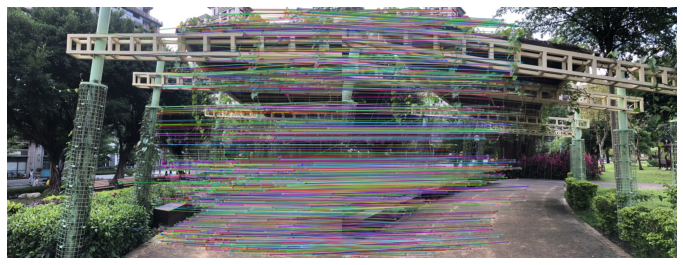

In [32]:
def filter_matches(matches, ratio = 0.6):
    good = []
    for m,n in matches:
        if m.distance < ratio * n.distance:
            good.append([m])
    return good
sift = cv2.SIFT_create()
matcher = cv2.BFMatcher(cv2.NORM_L2)
img1, img2 = cv2.imread('./Data/01.jpg'), cv2.imread('./Data/02.jpg')
img1_gray, img2_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
kp1, des1 = sift.detectAndCompute(img1_gray, None)
kp2, des2 = sift.detectAndCompute(img2_gray, None)
raw_matches = matcher.knnMatch(des1, des2, k=2)
good_r6 = filter_matches(raw_matches, ratio=0.6)

result = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good_r6,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
fig, ax = plt.subplots(figsize=(12,10))
ax.imshow(cv2.cvtColor(result, cv2.cv2.COLOR_BGR2RGB))
ax.axis('off')
plt.show()

### 2. Homography and stitching. (50%)
#### Please calculate the homography matrix with the point correspondences that detect from the first part. Also, warp the images and stitch them together. (cv2.Sticher is not allowed in this part)
##### (Example figure)
![figure2.jpg](https://github.com/tingyan08/Deep-Learning-and-Computer-Vision/blob/main/HW6/fig/figure2.jpg?raw=true)

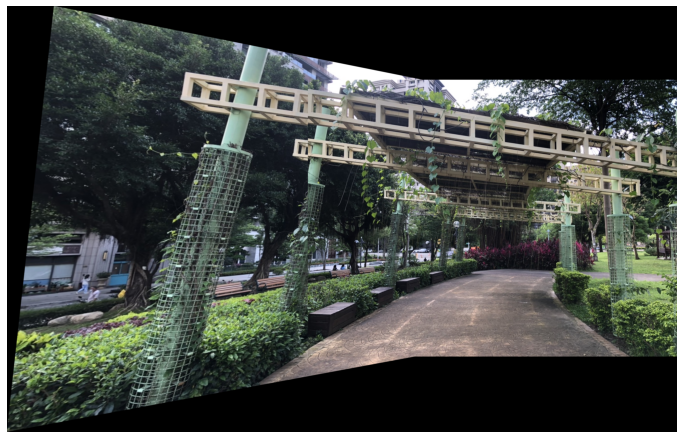

In [34]:
def warpImages(img1, img2, H):
  """
  Ref:https://datahacker.rs/005-how-to-create-a-panorama-image-using-opencv-with-python/
  """
  rows1, cols1 = img1.shape[:2]
  rows2, cols2 = img2.shape[:2]

  list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
  temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)

  # When we have established a homography we need to warp perspective
  # Change field of view
  list_of_points_2 = cv2.perspectiveTransform(temp_points, H)

  list_of_points = np.concatenate((list_of_points_1,list_of_points_2), axis=0)

  [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
  [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)
  
  translation_dist = [-x_min,-y_min]
  
  H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

  output_img = cv2.warpPerspective(img2, H_translation.dot(H), (x_max-x_min, y_max-y_min))
  output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1

  return output_img

src_pts = np.float32([ kp1[m[0].queryIdx].pt for m in good_r6]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m[0].trainIdx].pt for m in good_r6]).reshape(-1,1,2)
M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
result = warpImages(img2, img1, M)
plt.figure(figsize=(12,10))
plt.imshow(result[:,:,::-1])
plt.axis("off")
plt.show()

### 3. (Bonus) Warping transformation (10%)
#### Please read the tutorials and the documentations of __cv2.Stitcher__, and  compare the differences between the panorama below and the panorama from the last question. Write down your observation. 
##### ___(No need to implement for this part!)___

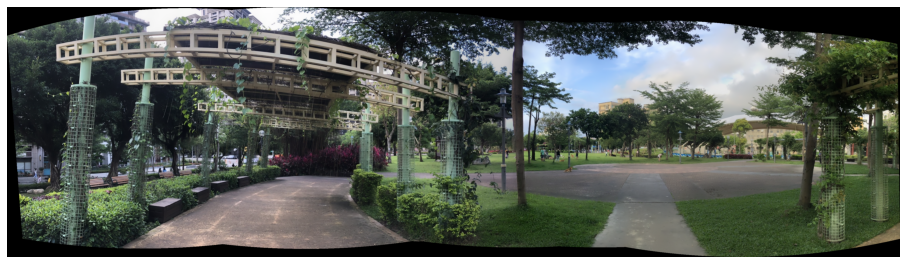

In [36]:
path = "./Data"
img_list = [cv2.imread(i) for i in sorted(glob.glob(os.path.join(path, "*.jpg")))]
sticher = cv2.Stitcher_create(cv2.Stitcher_PANORAMA)
ret, pano = sticher.stitch(img_list)
plt.figure(figsize=(16,8))
plt.imshow(pano[:,:,::-1])
plt.axis("off")
plt.show()

### The panorama of 2 is created by simply applying homography to img1 and then stitching directly to img2. There's no significant distortion and the joint between the two images is clearly to tell. The panorama of 3 is found to have apparent distortion in each stitched image. The edges of stitched images don't remain straight lines as the panorama of 2. 